# Image Classification: Tuberculosis Detection from Chest X-rays

## Overview
* This project focuses on leveraging Deep Learning and Computer Vision techniques to aid in the diagnosis of Tuberculosis (TB), a severe global health issue. By analyzing Chest X-ray (CXR) images, the goal is to create an automated classification system that can accurately distinguish between healthy patients and those showing signs of TB.

* The implementation involves exploring two distinct model approaches: a Custom Convolutional Neural Network (CNN) trained from scratch and a powerful Transfer Learning approach utilizing the pre-trained MobileNetV2 architecture. The project demonstrates the full machine learning lifecycle, from data processing and augmentation to model training, evaluation, and recommendation for deployment. The ultimate aim is to provide a fast, objective, and high-sensitivity screening tool to support clinical decision-making, particularly in resource-limited settings.

## The Data
  
You are given a small dataset from the Sakha-TB dataset.

These images are in the data.zip file at the root of the notebook. They will then be in the data/chestxray folder, which is further divided into test and train, both containing healthy and tb folders with the images inside.

## Problem Statement
Tuberculosis remains one of the world's leading infectious disease killers. Traditional diagnostic methods, such as sputum smear microscopy, can be slow, resource-intensive, and prone to error. While Chest X-rays are widely used for screening and diagnosis, their interpretation relies heavily on the expertise and availability of trained radiologists, which is often a major bottleneck, especially in areas with a high TB burden.


## The Objective
* The core problem is the need for a reliable, rapid, and scalable automated pre-screening tool that can efficiently process Chest X-ray images. This tool must meet a critical performance requirement: minimizing False Negatives (missing a TB case), as this could have severe public health consequences. Therefore, the developed model must achieve a high Recall (Sensitivity) score while maintaining strong overall accuracy.

## Objectives
 The project is guided by the following specific objectives:

1. Data Preparation and Exploration: Successfully load, structure, and augment the chest X-ray dataset into training, validation, and test sets, ensuring proper class balance.

2. Model Development and Benchmarking: Implement and train two distinct deep learning architectures (Custom CNN and MobileNetV2 via Transfer Learning) to classify images as either 'healthy' or 'tb'.

3. Performance Optimization: Employ techniques like Early Stopping and ReduceLROnPlateau to optimize model training, minimize overfitting, and improve convergence.

4. Rigorous Evaluation: Quantitatively evaluate both models using key metrics—Accuracy, Precision, and Recall—on a dedicated, unseen test dataset.

5. Selection and Recommendation: Select the superior model (MobileNetV2, due to its high test recall of 80%) and provide concrete recommendations for its further refinement and potential clinical deployment.

# Stakeholders
1. Public Health Organizations (e.g., WHO, CDC)
2. Clinicians
3. Radiologists

# Import Libraries

In [1]:
#import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import imageio.v2 as imageio
import random
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from IPython.display import Markdown, display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc







Here we check to see if the folder data/chestxrays exists. If it does not, it opens the data.zip file and extracts all of its contents into the current working directory, likely creating the needed folder structure.

### Extracting the contents from the folder

In [2]:
# Unzip the data folder
if not os.path.exists('data/chestxrays'):
    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        zip_ref.extractall()

## Data exploration

The dataset has been successfully extracted and organized into the following structure:
* Training Images
* Test Images
* Test Images

Each folder contains two subdirectories: healthy and tb, representing the two classes for classification. The dataset is balanced across the two classes, allowing for reliable training and evaluation of the deep learning models.

In [3]:
#data exploration
path = '/content/data/chestxrays'
train_dir = os.path.join(path,'train')
test_dir = os.path.join(path, 'test')

#health dataset
train_healthy_dir = os.path.join(train_dir, 'healthy')
test_healthy_dir = os.path.join(test_dir, 'healthy')
#tb dataset
train_tb_dir = os.path.join(train_dir, 'tb')
test_tb_dir = os.path.join(test_dir, 'tb')

#results
print('total training healthy images:', len(os.listdir(train_healthy_dir)))
print('total training tb images:', len(os.listdir(train_tb_dir)))
print('total testing healthy images:', len(os.listdir(test_healthy_dir)))
print('total testing tb images:', len(os.listdir(test_tb_dir)))


total training healthy images: 152
total training tb images: 151
total testing healthy images: 50
total testing tb images: 50


# EDA

## Analyzing the pixel distribution

Here, we perform basic data visualization. We load samples of healthy and TB images, then print their shape and data type. We also check whether the images are grayscale or color. Finally, we visualize the pixel intensity distribution of both images using histograms to provide insights into their characteristics.



--- Healthy Image Properties ---
Shape: (224, 224)
Data Type: uint8

--- TB Image Properties ---
Shape: (224, 224)
Data Type: uint8
Grayscale Check: Healthy is Grayscale | TB is Grayscale


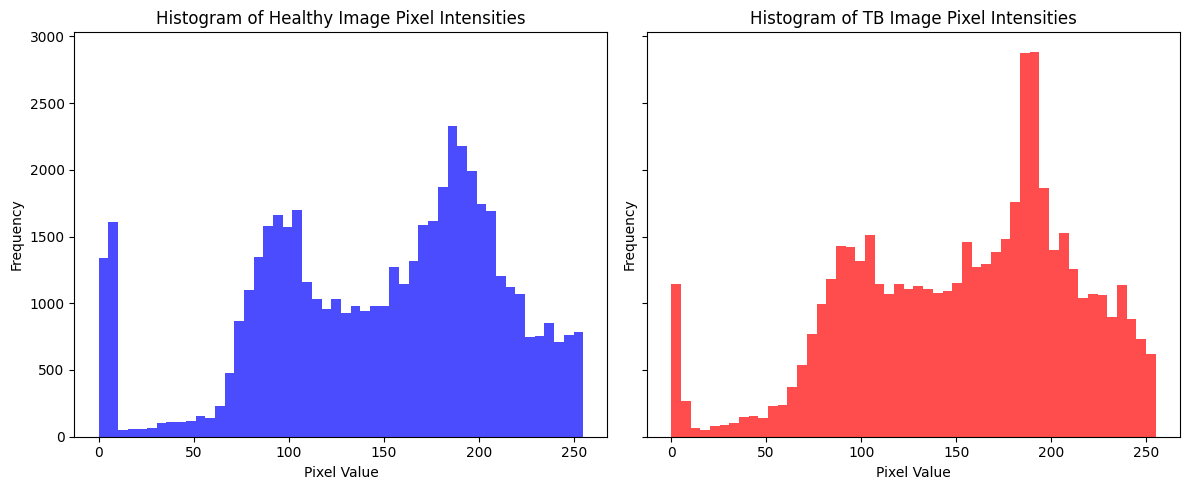

In [4]:
def analyze_image_properties(healthy_img_path, tb_img_path):
    # Load images into numpy arrays
    healthy_img = imageio.imread(healthy_img_path)
    tb_img = imageio.imread(tb_img_path)

    print("--- Healthy Image Properties ---")
    print(f"Shape: {healthy_img.shape}")
    print(f"Data Type: {healthy_img.dtype}")

    print("\n--- TB Image Properties ---")
    print(f"Shape: {tb_img.shape}")
    print(f"Data Type: {tb_img.dtype}")

    # Check for grayscale status using the array's dimensions
    is_healthy_gray = healthy_img.ndim < 3 or healthy_img.shape[-1] < 3
    is_tb_gray = tb_img.ndim < 3 or tb_img.shape[-1] < 3

    print(f"Grayscale Check: Healthy is {'Grayscale' if is_healthy_gray else 'Color'} | "
          f"TB is {'Grayscale' if is_tb_gray else 'Color'}")

    # Plot histograms of pixel intensities
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    axes[0].hist(healthy_img.flatten(), bins=50, color='blue', alpha=0.7)
    axes[0].set_title('Histogram of Healthy Image Pixel Intensities')
    axes[0].set_xlabel('Pixel Value')
    axes[0].set_ylabel('Frequency')

    axes[1].hist(tb_img.flatten(), bins=50, color='red', alpha=0.7)
    axes[1].set_title('Histogram of TB Image Pixel Intensities')
    axes[1].set_xlabel('Pixel Value')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Define sample paths (needed if this cell is run independently)
sample_healthy_file = os.listdir(train_healthy_dir)[0]
sample_healthy_path = os.path.join(train_healthy_dir, sample_healthy_file)

sample_tb_file = os.listdir(train_tb_dir)[0]
sample_tb_path = os.path.join(train_tb_dir, sample_tb_file)

# Analyze properties using the paths defined above
analyze_image_properties(sample_healthy_path, sample_tb_path)

## Image Data Generators

Here, we set up data generators for training, validation, and testing. We apply rescaling and augmentation to the training data, split the dataset for validation, ensure grayscale images, and define batch size and shuffling. Finally, we print the number of images in each set.

In [5]:
# Set random seed for reproducibility
np.random.seed(42)



train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    validation_split=0.2
)

# Training Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    color_mode='grayscale',
    subset='training',
    shuffle=True,
    seed = 42
)

#Validation Generator
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Validation Generator
validation_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation',
    shuffle=True,
    seed = 42
)


#Define the Test Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Instantiate the Test Generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

# Print final counts
print(f"Training Images: {train_generator.samples}")
print(f"Validation Images: {validation_generator.samples}")
print(f"Testing images: {test_generator.samples}")

Found 242 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Training Images: 242
Validation Images: 60
Testing images: 100


### Results

* The train generator has 242 images for training (from the directory, 80% of original data due to validation_split=0.2).

* The validation generator has 60 images (20% of the training directory).

* The test generator has 100 images (from the test directory, separate from training/validation).

* Each set has 2 classes (e.g., “healthy” and “TB”).

This confirms that the dataset is correctly split into training, validation, and test sets.

## Visualizing augmented images

Displaying sample augmented training images:


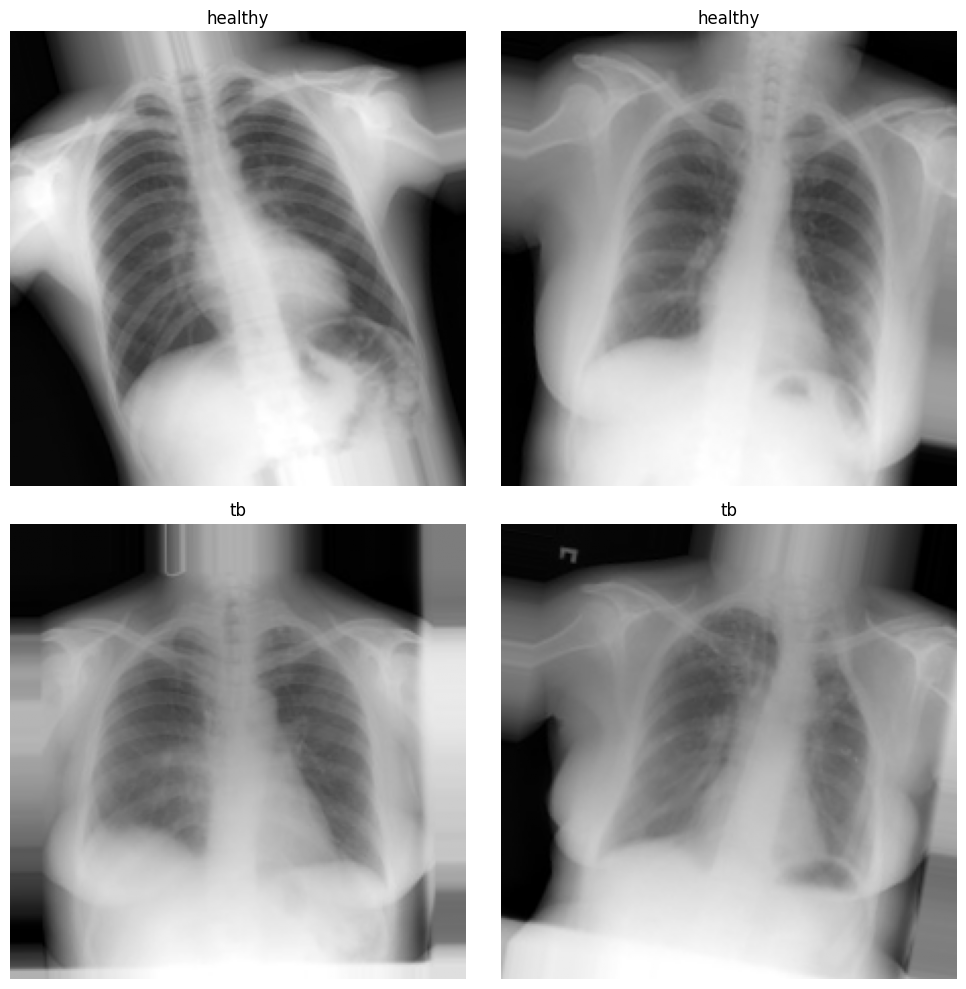

In [6]:
def display_augmented_images(generator, num_images=4):
    # Get a batch of augmented images and their labels
    images, labels = next(generator)

    # Get the class names from the generator's class_indices

    class_names = {v: k for k, v in generator.class_indices.items()}

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(2, 2, i + 1)
        # Display the image
        plt.imshow(images[i].reshape(224, 224), cmap='gray')
        # Display the actual class name based on the label
        plt.title(class_names[int(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print('Displaying sample augmented training images:')
display_augmented_images(train_generator)

Here, we visualize sample images from the training generator to inspect the effect of data augmentation. We select a batch of images, apply any augmentations defined in the generator (such as rotation, zoom, or shifts), and display a few images in grayscale along with their corresponding class labels. This helps verify that the augmentation is applied correctly and that the images are labeled as expected before training the model.

# Creating a simple CNN model

Built from scratch with convolution, pooling, dropout, and dense layers.



In [7]:
#creating a simple cnn model
cnn_model = models.Sequential([
    layers.Input(shape=(224, 224, 1)),
    #layer 1
    layers.Conv2D(32, (3,3), activation = 'relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    #layer 2
    layers.Conv2D(32, (3,3), activation = 'relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),


    #flatten
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation = 'sigmoid')



])

#print the summary
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,854,881 (49.04 MB)

 Trainable params: 12,854,881 (49.04 MB)

 Non-trainable params: 0 (0.00 B)

## Early Stopping and Learning Rate Reduction



In [8]:
# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=1e-7,
    verbose=1

)

# Re-compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       Precision(),
                       Recall(),
                       ])

# Train the model with the Early Stopping callback
cnn_history_early_stop = cnn_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4666 - loss: 0.8612 - precision: 0.4466 - recall: 0.3313 - val_accuracy: 0.5167 - val_loss: 0.6924 - val_precision: 0.5161 - val_recall: 0.5333 - learning_rate: 1.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5118 - loss: 0.7561 - precision: 0.5227 - recall: 0.5664 - val_accuracy: 0.6000 - val_loss: 0.6921 - val_precision: 0.6364 - val_recall: 0.4667 - learning_rate: 1.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6470 - loss: 0.6654 - precision: 0.5980 - recall: 0.3465 - val_accuracy: 0.5000 - val_loss: 0.6955 - val_precision: 0.5000 - val_recall: 0.9333 - learning_rate: 1.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5211 - loss: 0.6885 - precision: 0.5086 - recall: 0.7169 - val_accuracy: 0.5167 - val_loss: 0.6933 - val_precision: 1.0000 - val_recall: 0.0333 - learning_rate: 1.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accu

The model showed steady training improvement, reaching 64% accuracy with rising precision and recall. However, validation metrics remained flat, with accuracy around 50–55% and unstable precision/recall, indicating overfitting. Early stopping at epoch 21 restored weights from epoch 6, where validation loss was lowest (0.6912), confirming that generalization peaked early.

## Training and Validation Metrics

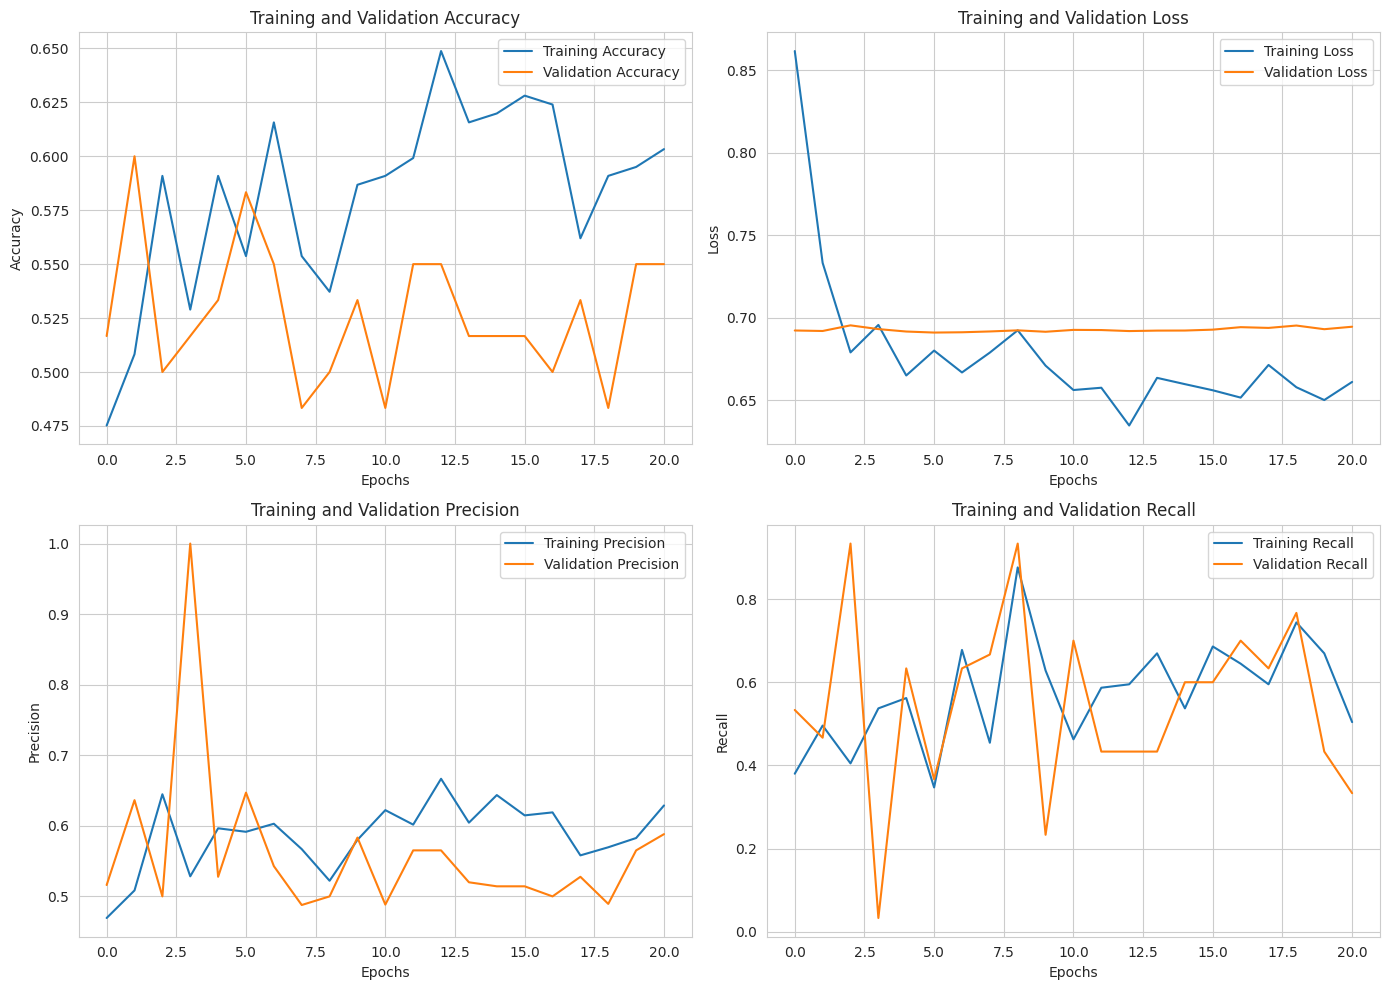

In [9]:
# Set a Seaborn whitegrid
sns.set_style("whitegrid")

# Define the metrics to be plotted and their labels
plot_metrics = [
    ('accuracy', 'val_accuracy', 'Accuracy', 1),
    ('loss', 'val_loss', 'Loss', 2),
    ('precision', 'val_precision', 'Precision', 3),
    ('recall', 'val_recall', 'Recall', 4)

]

# Get the range of epochs
epochs_range = range(len(cnn_history_early_stop.history['accuracy']))

# Create a figure for all plots
plt.figure(figsize=(14, 10))

# Loop through the metrics
for train_key, val_key, title, index in plot_metrics:
    # Retrieve the data for the current metric
    train_data = cnn_history_early_stop.history[train_key]
    val_data = cnn_history_early_stop.history[val_key]

    # Create the subplot and plot the lines
    plt.subplot(2, 2, index)
    plt.plot(epochs_range, train_data, label=f'Training {title}')
    plt.plot(epochs_range, val_data, label=f'Validation {title}')

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.title(f'Training and Validation {title}')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()



The training metrics steadily improve across epochs, while validation metrics remain mostly flat and unstable—indicating overfitting. Precision and recall on validation data fluctuate, suggesting inconsistent detection of TB cases.

## Transfer Learning - MobileNetV2 Model

Pre-trained on ImageNet, fine-tuned for TB classification.

In [10]:
# Reset the generators
train_generator.reset()
validation_generator.reset()

#mobilev2 training model
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

mobile_ml = models.Sequential([
    layers.Input(shape=(224, 224, 1)),
    layers.Lambda(lambda x: tf.concat([x, x, x], axis=-1)),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# ============================
# COMPILE MODEL
# ============================
mobile_ml.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(),
                       Recall()]
)


#define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

#train the model with the early stopping
history = mobile_ml.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Training Complete!")


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 958ms/step - accuracy: 0.4910 - loss: 1.0262 - precision_1: 0.6008 - recall_1: 0.2555 - val_accuracy: 0.4667 - val_loss: 0.7669 - val_precision_1: 0.4808 - val_recall_1: 0.8333 - learning_rate: 1.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 827ms/step - accuracy: 0.4958 - loss: 0.9611 - precision_1: 0.4779 - recall_1: 0.4897 - val_accuracy: 0.4500 - val_loss: 0.7764 - val_precision_1: 0.4737 - val_recall_1: 0.9000 - learning_rate: 1.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 833ms/step - accuracy: 0.5919 - loss: 0.7692 - precision_1: 0.6084 - recall_1: 0.5257 - val_accuracy: 0.4667 - val_loss: 0.8027 - val_precision_1: 0.4828 - val_recall_1: 0.9333 - learning_rate: 1.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 831ms/step - accuracy: 0.5418 - loss: 0.8674 - precision_1: 0.5839 - recall_1: 0.6310 - val_accuracy: 0.4500 - val_loss: 0.7611 - val_precision_1: 0.4737 - val_recall_1: 0.9000 - learning_rate: 1.0000e-04
Epoch 5/50
1

## Overall interpretation
The model shows moderate learning progress on the training set, with accuracy rising to 62% and precision/recall stabilizing around 0.64 and 0.61 respectively. However, validation metrics remain flat, with accuracy stuck at 48–50%, and precision hovering near 0.49 across epochs.

* Loss: Training loss decreases from 1.03 to 0.67, but validation loss stays around 0.72, indicating limited generalization.

* Precision: Training precision improves, but validation precision remains low and stable (0.48–0.50), suggesting weak confidence in positive predictions.

* Recall: Validation recall is consistently high (0.80–0.93), meaning the model captures most true positives but likely at the cost of false positives.

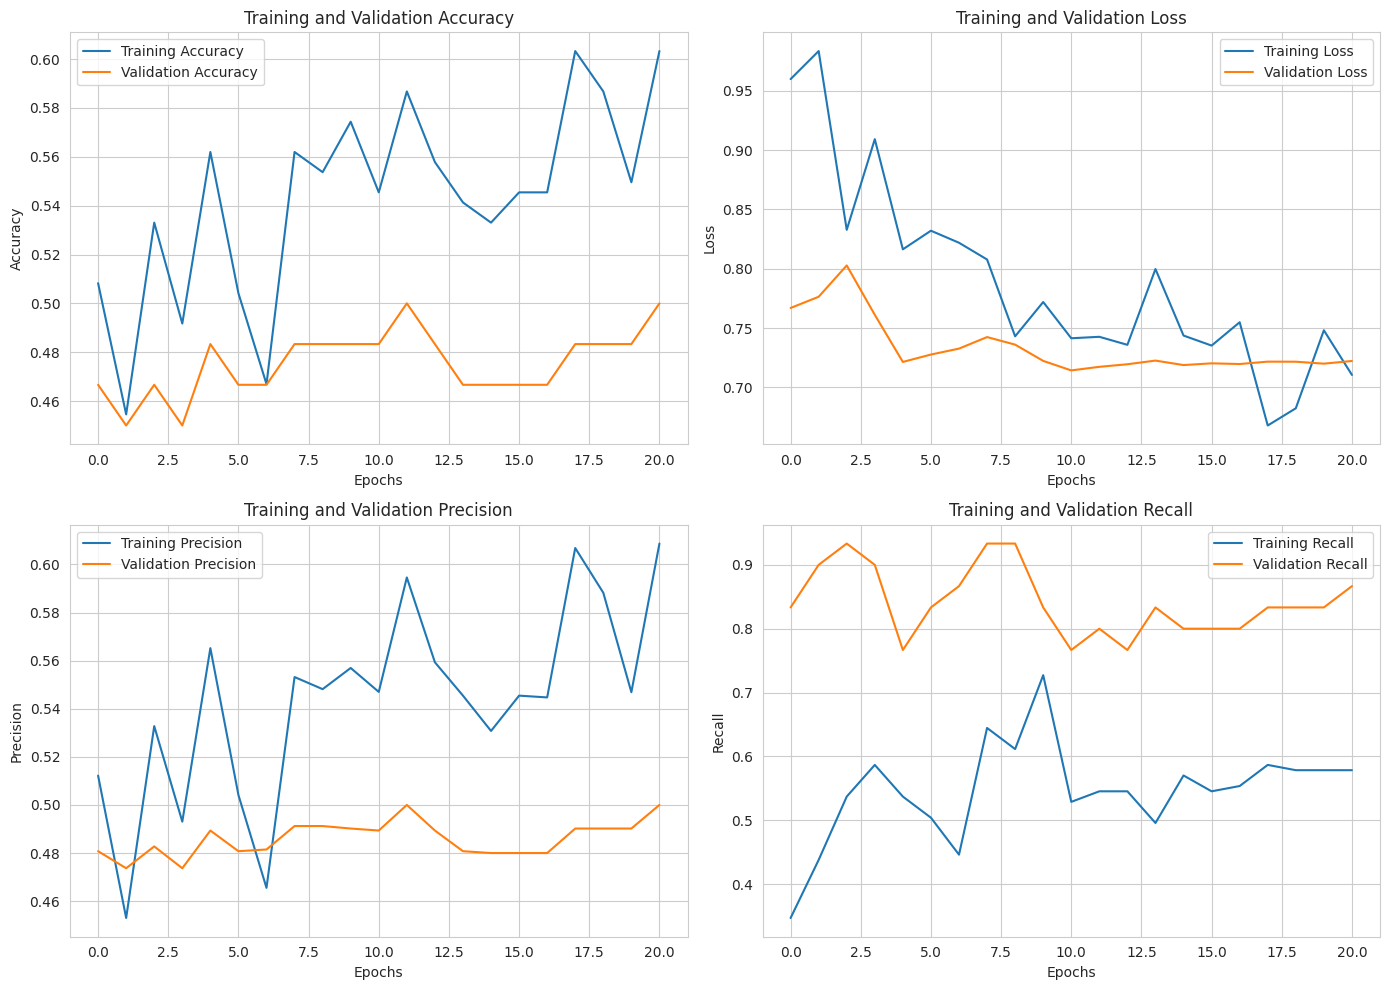

In [11]:
# Set a Seaborn whitegrid
sns.set_style("whitegrid")

# Define the metrics to be plotted and their labels
plot_metrics = [
    ('accuracy', 'val_accuracy', 'Accuracy', 1),
    ('loss', 'val_loss', 'Loss', 2),
    ('precision_1', 'val_precision_1', 'Precision', 3),
    ('recall_1', 'val_recall_1', 'Recall', 4),

]

# Get the range of epochs
epochs_range = range(len(history.history['accuracy']))

# Create a figure for all plots
plt.figure(figsize=(14, 10))

# Loop through the metrics
for train_key, val_key, title, index in plot_metrics:
    # Retrieve the data for the current metric
    train_data = history.history[train_key]
    val_data = history.history[val_key]

    # Create the subplot and plot the lines
    plt.subplot(2, 2, index)
    plt.plot(epochs_range, train_data, label=f'Training {title}')
    plt.plot(epochs_range, val_data, label=f'Validation {title}')

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.title(f'Training and Validation {title}')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()

## Metric Breakdown
* Accuracy: Training improves (62%), validation stays low (48–50%).

* Loss: Training decreases, validation remains flat (0.72).

* Precision: Training rises (0.64), validation stays low (0.48–0.50).

* Recall: Training stabilizes (0.61), validation stays high (0.80–0.93).

## Evaluation

### Confusion Matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step

 Custom CNN Test Results
Accuracy:  0.7100
Precision: 1.0000
Recall:    0.4200


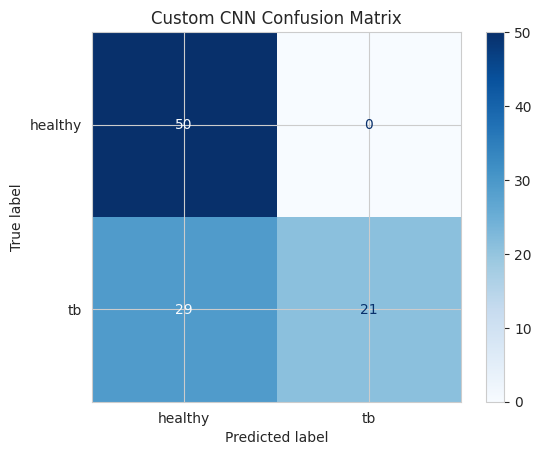

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step

 MobileNetV2 Test Results
Accuracy:  0.8700
Precision: 0.8936
Recall:    0.8400


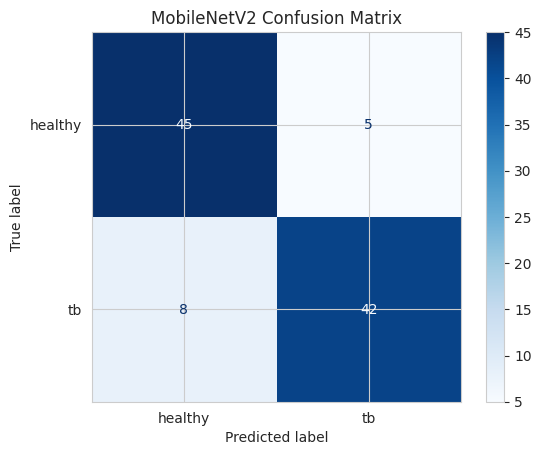

In [12]:
# Extract all test data once
test_generator.reset()

X_test = []
y_test = []

for i in range(len(test_generator)):
    data_batch, label_batch = test_generator[i]
    X_test.append(data_batch)
    y_test.append(label_batch)

X_test = np.vstack(X_test)
y_test = np.concatenate(y_test).ravel()


def evaluate_model_single_pass(model, X, y, model_name="Model"):
    # Predictions once
    preds = model.predict(X)
    pred_labels = (preds > 0.5).astype(int)

    # Metrics
    accuracy = accuracy_score(y, pred_labels)
    precision = precision_score(y, pred_labels)
    recall = recall_score(y, pred_labels)
    cm = confusion_matrix(y, pred_labels)

    # Print metrics
    print(f"\n {model_name} Test Results")
    print("="*40)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    return preds, pred_labels, cm, accuracy, precision, recall

cnn_results = evaluate_model_single_pass(cnn_model, X_test, y_test, "Custom CNN")
mobilenet_results = evaluate_model_single_pass(mobile_ml, X_test, y_test, "MobileNetV2")



 ## CNN Metric Interpretation
* Accuracy (71%): The model correctly classified 71% of all test samples overall.

* Precision (100%): Every TB prediction made by the model was correct — no false positives.

* Recall (42%): The model only identified 42% of actual TB cases, missing more than half.

The Custom CNN is highly precise but conservative — it avoids false alarms but fails to detect many true TB cases. This results in low recall, which is risky in medical diagnostics where missing a positive case can have serious consequences. The model favors specificity over sensitivity, making it reliable for confirming TB but not ideal for screening.

## MobileNetV2 Metric Interpretation

The model achieved 87% accuracy, showing high overall correctness in predictions.

* Precision (89.4%): Most TB predictions were correct, with very few false positives.

* Recall (84%): It successfully identified the majority of actual TB cases, minimizing false negatives.

MobileNetV2 demonstrates balanced and reliable performance, making it well-suited for medical screening tasks. It combines high confidence in positive predictions with strong sensitivity, meaning it can detect TB cases effectively without overpredicting.

In [13]:
# calculate medical metrics from a confusion matrix
def calculate_medical_metrics(cm):
  #flatten
    TN, FP, FN, TP = cm.ravel()
    return {
        'Sensitivity': TP / (TP + FN) if (TP + FN) > 0 else 0,
        'Specificity': TN / (TN + FP) if (TN + FP) > 0 else 0,
        'PPV': TP / (TP + FP) if (TP + FP) > 0 else 0,
        'NPV': TN / (TN + FN) if (TN + FN) > 0 else 0
    }

# Calculate metrics
cnn_metrics = calculate_medical_metrics(cnn_results[2])
mobilenet_metrics = calculate_medical_metrics(mobilenet_results[2])

# Create a DataFrame for tabular display
metrics_df = pd.DataFrame({
    'Custom CNN': cnn_metrics,
    'MobileNetV2': mobilenet_metrics
}).round(4)

display(metrics_df)



,Custom CNN,MobileNetV2
Sensitivity,0.4200,0.8400
Specificity,1.0000,0.9000
PPV,1.0000,0.8936
NPV,0.6329,0.8491


## Overall Interpretation

* Custom CNN is extremely cautious: it avoids false positives entirely (100% precision and specificity), but misses many true TB cases (low sensitivity and NPV).

* MobileNetV2 offers a balanced profile, detecting most TB cases (84% sensitivity) while maintaining high precision and specificity — making it more suitable for screening and general diagnosis.


GENERATING ROC CURVES


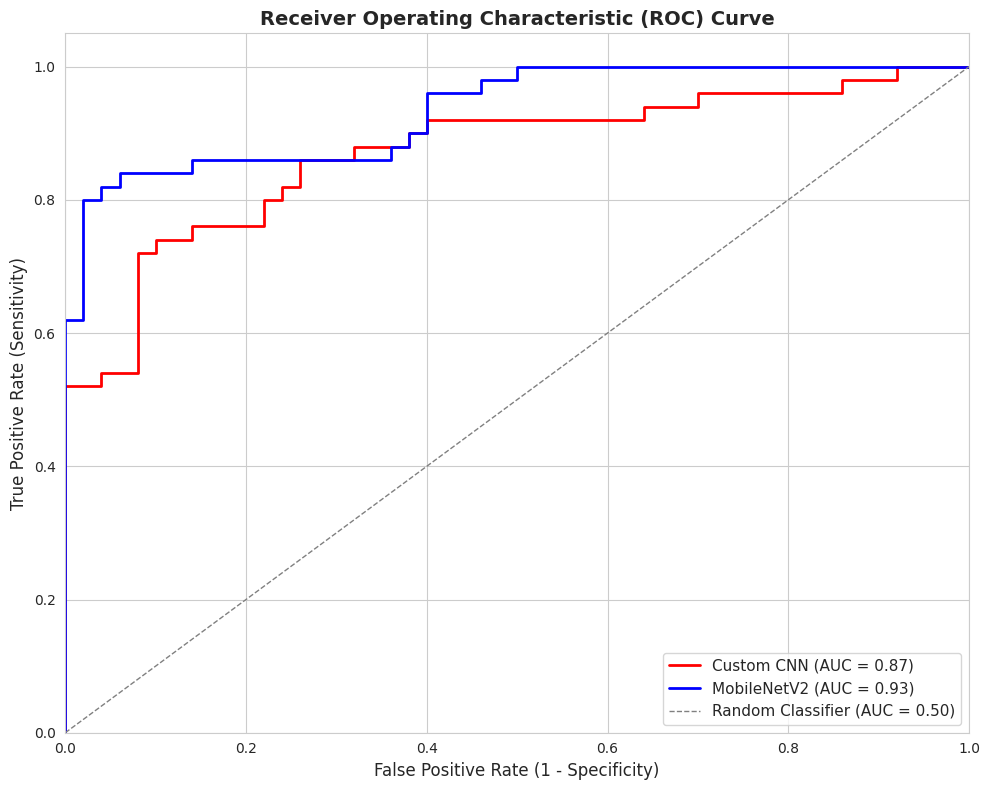

In [15]:
#plotting the ROC curve
print("\n" + "="*60)
print("GENERATING ROC CURVES")
print("="*60)

test_generator.reset()

# Get true labels
y_true = test_generator.classes

# --- Custom CNN ---
# Get prediction probabilities for the Custom CNN
y_pred_cnn = cnn_model.predict(test_generator, verbose=0).ravel()

# Calculate ROC curve points and AUC for Custom CNN
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_true, y_pred_cnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)

# --- MobileNetV2 ---
# Reset generator again before MobileNetV2 predictions
test_generator.reset()
# Get prediction probabilities for MobileNetV2
y_pred_mobilenet = mobile_ml.predict(test_generator, verbose=0).ravel()

# Calculate ROC curve points and AUC for MobileNetV2
fpr_mobilenet, tpr_mobilenet, thresholds_mobilenet = roc_curve(y_true, y_pred_mobilenet)
auc_mobilenet = auc(fpr_mobilenet, tpr_mobilenet)

# --- Plotting ROC Curves ---
plt.figure(figsize=(10, 8))
plt.plot(fpr_cnn, tpr_cnn, color='red', lw=2, label=f'Custom CNN (AUC = {auc_cnn:.2f})')
plt.plot(fpr_mobilenet, tpr_mobilenet, color='blue', lw=2, label=f'MobileNetV2 (AUC = {auc_mobilenet:.2f})')

# Plot the random classifier line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.show()



## ROC Curve Analysis
* MobileNetV2 (AUC = 0.93): Delivers excellent diagnostic performance, with high sensitivity and specificity across thresholds.

* Custom CNN (AUC = 0.87): Performs well but slightly below MobileNetV2, showing solid discrimination ability.

## Overall Interpretation
MobileNetV2 clearly outperforms the Custom CNN, offering more reliable classification of TB cases. Its higher AUC reflects better generalization and threshold stability, making it the stronger choice for medical screening.

## Conclusions
1. MobileNetV2 Outperforms Custom CNN: The transfer learning model using MobileNetV2 significantly outperformed the custom-built CNN. MobileNetV2 achieved a test accuracy of 87% with a balanced precision of 89.36% and recall of 84%. Its ROC AUC of 0.93 demonstrates superior overall discriminative power.

2. Custom CNN's Limitations: While the custom CNN showed high precision (100% on the test set, meaning no false positives), its very low recall (42%) is a major drawback for medical diagnostics. It would miss more than half of the actual TB cases, making it unsuitable for screening or reliable diagnosis. Its ROC AUC of 0.87, though respectable, was lower than MobileNetV2.

3. Overfitting in Both Models: Both models exhibited signs of overfitting during training, where training metrics improved steadily, but validation metrics remained relatively flat or unstable. This suggests that with the current dataset size and augmentation strategy, the models struggled to generalize perfectly to unseen data within the training distribution.



## Recommendations
1. Adopt MobileNetV2 as the Primary Model: Given its superior and more balanced performance, MobileNetV2 should be chosen for further development and deployment. Its high sensitivity (84%) is particularly vital in medical screening, as it minimizes the risk of missing actual disease cases.

2. Increase Dataset Size and Diversity: The current dataset is relatively small (242 training, 60 validation, 100 test images). Expanding the dataset with more diverse chest X-ray images, perhaps from different sources or modalities, would likely improve generalization and reduce overfitting.

3. Explore Advanced Augmentation Techniques: While basic augmentation was applied, more sophisticated techniques (e.g., CutMix, MixUp, elastic deformations) could be explored to further enhance data diversity and model robustness, especially with a limited dataset.

4. Fine-tuning MobileNetV2 (Unfreeze Layers): While the base_model was initially frozen, further performance gains might be achieved by unfreezing and fine-tuning a few of the top layers of MobileNetV2 after initial training. This allows the pre-trained weights to adapt more specifically to the TB classification task.


